In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
# transform: 이미지를 torch tensor를 읽고 변환해주는 라이브러리
# normalize: 이미지 tensor들을 정규화, 0.5는 normalize하는 일종의 기준 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Validation set 만들기 위해 training set split
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])    

    
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


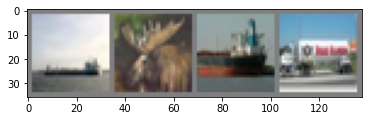

ship  deer  ship  truck
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([8, 4, 8, 9])


In [3]:
# 사진 Inspect, 채널을 잘못불러올경우 이미지가 엉망일 수 있으니 한번 검사해야됨

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

print(type(images), images.shape) # image type이 torch.tensor
print(type(labels), labels.shape, labels)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim  # orward에서도 이 값들을 사용하므로 input 인자들도 self로 넣어줌
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        # ModuleList에 hiddenlayer 넣음 (인풋레이어도 레이러로 친다면 self.n_layer-2적용)
        # self.n_layer-1을 한 이유는 마지막 outputlayer는 out_dim 따로 설정해야함
        for i in range(self.n_layer - 1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

net = MLP(3072, 10, 100, 4, 'relu')
print(net)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
            
        inputs, labels = data
        # Reshape 해줌 view (-1, X): X는 X 차원대로 맞추고 나머지는 알아서 맞춰라 (cf: 축을 바꿀 때는 axis swap씀)
        inputs = inputs.view(-1, 3*32*32)        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.243
[1,  4000] loss: 1.922
[1,  6000] loss: 1.804
[1,  8000] loss: 1.737
[1, 10000] loss: 1.675
[1, 12000] loss: 1.626
[2,  2000] loss: 1.575
[2,  4000] loss: 1.555
[2,  6000] loss: 1.519
[2,  8000] loss: 1.522
[2, 10000] loss: 1.516
[2, 12000] loss: 1.483
Finished Training


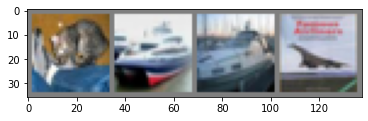

GroundTruth:  cat   ship  ship  plane


In [7]:
#testset inspect

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 3*32*32)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 47 %


## 돌아가는 것을 관측한다. 그다음 스텝은?
- Validation

In [15]:
correct = 0
total = 0
val_loss = 0 # Val_loss 추가
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.view(-1, 3*32*32)
        # calculate outputs by running images through the network
        outputs = net(images)
        # loss 추가 
        loss = criterion(outputs, labels)
        val_loss += loss.item()        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(valloader) # Val_loss / batch 덩이 갯수 
    print(len(valloader))
    print(val_loss)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

2500
1.3749848453938962
Accuracy of the network on the 10000 test images: 51 %
